In [2]:
import glob
import pybrain
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer, SigmoidLayer
from pybrain.structure import FullConnection
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import random
import ast
import time
import sqlalchemy
from sqlalchemy import *
from sqlalchemy import event
import sqlite3
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import *
import urllib2
import urllib
import json
import glob
import pprint
import dateutil.parser
import pprint
import re
from sklearn import linear_model, datasets
import time
from sklearn.naive_bayes import GaussianNB
import nltk
from collections import defaultdict
from sklearn import svm
pp = pprint.PrettyPrinter(indent=4)


import numpy
import time
import sqlalchemy
from sqlalchemy import *
from sqlalchemy import event
from sqlalchemy.dialects.mysql import LONGTEXT
import sqlite3
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import *
import urllib2
import urllib
import json
import pprint
import dateutil.parser
import gevent
import datetime
import marshal

import re, math, collections, itertools
import nltk, nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist
import numpy as np
import csv
import re
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
import os
import copy

from __future__ import division  # Python 2 users only
import nltk, re, pprint
from nltk import word_tokenize

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from nltk.corpus import wordnet as wn
from difflib import get_close_matches as gcm
from gensim.models.word2vec import Word2Vec
from pyemd import emd
import numpy as np
import math
from parse import *
from sympy import *
#init_printing(use_unicode=True)
from funcy import *
import urllib2

import os
from nltk.parse import stanford
import pydot
from nltk.stem.wordnet import WordNetLemmatizer

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


Couldn't import dot_parser, loading of dot files will not be possible.


does it even matter if the computer understands the meaning of a word?

Goal: convert natural language passage (temporal? ie story?) to an alternative structure that can then be read and used for summarization (as a (hard) example).

Idea: see if we can create a computer representation of knowledge (separate of nlp parsing), and then add teh nlp parsing stuff after

progression through state space


In [77]:
simple_text = True

In [96]:
raw = u"""Once upon a time, there were three little pigs who went off to build their houses.
The first little pig built his house of straw, which was not very strong.
One day, the big bad wolf came and said, “Little pig, little pig, let me come in.”
“Not by the hair of my chinny chin chin,” said the first little pig.
“Then I’ll huff and I’ll puff, and I’ll blow your house down.”
And he did. And he got the little pig and ate him all up.
The second little pig built his house of sticks, which were not very strong.
One day, the big bad wolf came and said, “Little pig, little pig, let me come in.”
“Not by the hair of my chinny chin chin,” said the second little pig.
“Then I’ll huff and I’ll puff and I’ll blow your house down.”
And he did. And he got the little pig and ate him all up.
The third little pig built his house of bricks, which were very strong.
One day, the big bad wolf came and said, “Little pig, little pig, let me come in.”
“Not by the hair of my chinny chin chin,” said the third little pig.
“Then I’ll huff and I’ll puff and I’ll blow your house down.”
But no matter how much the wolf huffed and puffed, the house did not blow down.
So the big bad wolf said, “I’ll come down the chimney and eat you all up.”
But when the wolf came down the chimney, he fell into a pot of boiling water and boiled all up.
And the third little pig lived happily ever after in his house of bricks.
The end."""

if simple_text:
    raw = u"""Three little pigs went off to build their houses.
    The first little pig built his house of straw, which was not very strong."""

In [97]:
# Not used, functions kept for reference
tokens = word_tokenize(raw)
text = nltk.Text(tokens)
tags = nltk.pos_tag(text)

def ie_preprocess(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

In [98]:
# Divide raw text into sentences
sentences = nltk.sent_tokenize(raw)

In [99]:
sentences[:2]

[u'Three little pigs went off to build their houses.',
 u'The first little pig built his house of straw, which was not very strong.']

In [100]:
# Load up the Stanford Parser. DOESN"T DO DEPENDENCY TREES (so not currently used)
os.environ['STANFORD_PARSER'] = '/home/ubuntu/projects/sat/stanford_parser'
os.environ['STANFORD_MODELS'] = '/home/ubuntu/projects/sat/stanford_parser'

parser = stanford.StanfordParser(model_path="/home/ubuntu/projects/sat/stanford_parser/englishPCFG.ser.gz")
#parsed_sentences = parser.raw_parse_sents(("Once upon a time, there were three little pigs who went off to build their houses.", "The first little pig built his house of straw, which was not very strong."))
parsed_sentences = parser.raw_parse_sents(sentences)

In [101]:
# Functions for Stanford Parsing dependency trees. Requires node server running.
def process_word(word) :
    return ''.join(ch for ch in word.lower() if ch.isalpha() or ch=='-')

def get_stanford_parse(sentence):
    #if sentence in parsed_sents :
    #    return parsed_sents[sentence]
    response = urllib2.urlopen("http://localhost:3000?sentence="+sentence.replace(' ','+')).read().replace('\n',' ')
    components = parse('[{}]  [{}] {}', response)
    parts = components[0].split(', ')
    pos={}
    for i in range(len(parts)) :
        word_and_pos = parse('{}/{}',parts[i].lower())
        pos[ process_word(word_and_pos[0])+'-'+str(i+1) ] = word_and_pos[1]
    deps = components[1]
    deps = deps.replace('),',')),').split('), ')
    deps = [parse('{}({}, {})',dep).fixed for dep in deps]
    deps = [(dep[0],dep[1][:dep[1].rfind('-')],dep[1][dep[1].rfind('-')+1:],dep[2][:dep[2].rfind('-')],dep[2][dep[2].rfind('-')+1:]) for dep in deps]
    labeled_deps = [(dep[0],process_word(dep[1]),dep[2],process_word(dep[3]),dep[4]) for dep in deps]
    deps = [(dep[0],process_word(dep[1]),process_word(dep[3])) for dep in deps]
    tree = components[2][:components[2].rfind('-')]
    tree = ' '.join(tree.split())
    p = components[2][components[2].rfind('-'):]
    #tree = response[end1+1:end2]
    #tree = ' '.join(tree.split())
    #p = float(response[end2:])
    #parsed_sents[sentence]=(deps,tree,p)
    #return (pos,deps,labeled_deps,tree,p)
    return labeled_deps

In [139]:
# Parse dependency tree
parsed_sentence = get_stanford_parse(sentences[1])

In [140]:
print parsed_sentence

[('det', 'pig', '4', 'the', '1'), ('amod', 'pig', '4', 'first', '2'), ('amod', 'pig', '4', 'little', '3'), ('nsubj', 'built', '5', 'pig', '4'), ('root', 'root', '0', 'built', '5'), ('poss', 'house', '7', 'his', '6'), ('dobj', 'built', '5', 'house', '7'), ('prep_of', 'house', '7', 'straw', '9'), ('nsubj', 'strong', '15', 'straw', '9'), ('cop', 'strong', '15', 'was', '12'), ('neg', 'strong', '15', 'not', '13'), ('advmod', 'strong', '15', 'very', '14'), ('rcmod', 'straw', '9', 'strong', '15')]


In [141]:
# Convert Dependency Tree to graphical png
def draw_dep_tree(original_sentence, parsed_sentence):
    print original_sentence
    graph = pydot.Dot(graph_type='digraph',font='verdana')
    for item in parsed_sentence:
        if item[0] == "root":
            node = pydot.Node(item[3] + " " + item[4], style = "filled")
            graph.add_node(node)
        else:
            node = pydot.Node(item[3] + " " + item[4])
            graph.add_node(node)
    for item in parsed_sentence:
        if item[1] != "root":
            graph.add_edge(pydot.Edge(item[1] + " " + item[2], item[3] + " " + item[4], label = item[0]))

    graph.write_png('dep_tree.png',prog='dot')

The first little pig built his house of straw, which was not very strong.


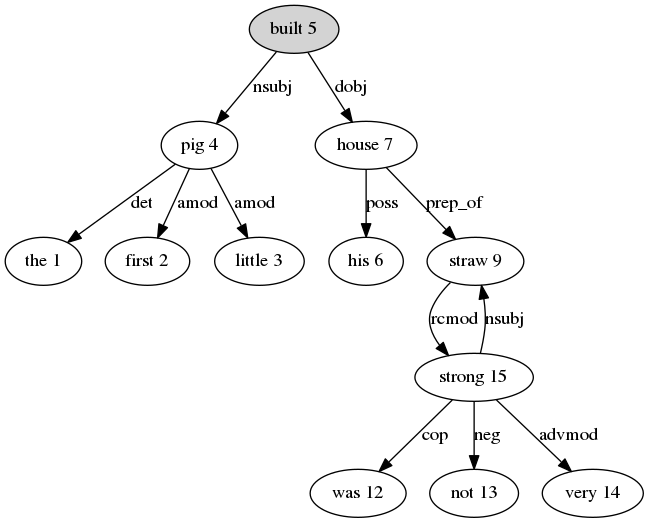

In [142]:
draw_dep_tree(sentences[1], parsed_sentence)
from IPython.display import Image
Image('dep_tree.png')

In [125]:
# ('nsubj', 'went', '4', 'pigs', '3')
def read_sentence(tree):
    for item in tree:
        if item[0] == "root":
            base_index = item[4]
    for item in tree:
        if item[0] == "nsubj" and item[2] == base_index:
            process_noun(item[3], tree, item[4])

In [137]:
def process_noun(word, tree, index):
    try:
        noun = copy.deepcopy(nouns[WordNetLemmatizer().lemmatize(word,'v')])
    except:
        print(noun + " not in dictionary")
    
    for item in tree:
        if item[2] == index:
            if item[0] == "num":
                noun.count = #convert to number
            if item[0] == "amod": #adjective
                process_adj(noun, item[1])

SyntaxError: invalid syntax (<ipython-input-137-476f1b03922b>, line 10)

In [136]:
def process_adj(noun, adjective):
    adjectives[adjective](noun)

Objects:

Pigs

Actions (time):

Went
Built

Consider verbs as unary or binary operators. Probability of correct interpretation is some function on the properties of the nouns it acts on. 

Consider adjectives as unary modifiers. They act to update the properties of their subject.

Think about things within a state space. Verbs signify motion of an object through state space (probably over time). Adjectives move the location of a noun in state space, but modify the previous location as opposed to making a new instance like a verb would do (as you want to know history for verbs, but not adjectives). Adjectives modify how verbs move nouns through the space. Verbs and adjectives can be considered functions on objects in state space. 

In [115]:
class Object:
    proper = False
    count = 1
    type = None
    def Object():
       pass

class Object_Type:
    abstract = False
    concrete = False

class Concrete:
    food = False
    complexity = None
    entity = False
    alive = False
    size = None

class Alive:
    mammal = False
    bird = False
    fish = False
    
class Action:
    duration = None
    motion = False

In [116]:
generic_object = Object()
generic_object.type = Object_Type()

concrete_object = copy.deepcopy(generic_object)
concrete_object.type.concrete = Concrete()

In [117]:
animal = copy.deepcopy(concrete_object)
animal.type.concrete.alive = Alive()
animal.type.concrete.size = 1 # longest dimension, meters
animal.type.concrete.complexity = 1000

In [118]:
pig = copy.deepcopy(animal)
animal.type.concrete.size = 1
pig.type.concrete.alive.mammal = True

house = copy.deepcopy(concrete_object)
house.type.concrete.size = 50
house.type.concrete.complexity = 10

In [119]:
nouns = {}
nouns["animal"] = animal
nouns["pig"] = pig
nouns["house"] = house

In [120]:
go = Action()
go.duration = 10 #minutes
go.motion = True

In [121]:
verbs = {}
verbs["go"] = go

In [132]:

words = ['smaller','went','going','dating']
for word in words:
    print word+"-->"+WordNetLemmatizer().lemmatize(word,'v')

smaller-->smaller
went-->go
going-->go
dating-->date


In [133]:
def little(noun):
    noun.type.concrete.size = noun.type.concrete.size * .75

In [134]:
adjectives = {}
adjectives["little"] = little